In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/DeepFake Detector'

/content/drive/MyDrive/Colab Notebooks/DeepFake Detector


In [3]:
%matplotlib inline
import numpy             as np
import matplotlib.pyplot as plt
import keras.backend     as K

from keras.models       import Sequential
from keras.layers       import Dense
from keras.layers       import BatchNormalization
from keras.layers       import Reshape
from keras.layers       import UpSampling2D
from keras.layers       import Convolution2D
from keras.layers       import Activation
from keras.layers       import Flatten
from keras.layers       import AveragePooling2D
from keras.optimizers   import Adam
from keras.datasets     import mnist

from tqdm import tqdm

from __future__ import division

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from numpy.random import seed

import tensorflow as tf

import keras
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import *
from keras.applications import *
from keras import metrics
from keras.losses import BinaryCrossentropy
from keras import backend as K

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [5]:
def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n = len(X_train)

X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

X = np.concatenate([X_train, X_test])
X = (X - 127.5) / 127.5
X = np.reshape(X, (-1, 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
IMG_HEIGHT, IMG_WIDTH = 299 , 299
EPOCHS = 20
DATA_GENERATOR_SEED = 1337
BACTH_SIZE = 256
VALIDATION_SPLIT = 0
LEARNING_RATE = 5e-2
DF_TYPE = 'rnd' # 'rnd', 'diff-bal', 'avg-bal', 'rnd-bal']

tf.random.set_seed(DATA_GENERATOR_SEED)
seed(DATA_GENERATOR_SEED)

TRAIN_VAL_DIR = f'./Celeb-DF-v2/Celeb-{DF_TYPE}'
if 'bal' in TRAIN_VAL_DIR:
    TEST_DIR = TRAIN_VAL_DIR.replace('bal', 'test')
else:
    TEST_DIR = f'{TRAIN_VAL_DIR}-test'

In [7]:
TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode='nearest',
                                   validation_split = VALIDATION_SPLIT)

VAL_DATAGEN = ImageDataGenerator(rescale = 1.0/255., 
                                 validation_split = VALIDATION_SPLIT)

TEST_DATAGEN = ImageDataGenerator(rescale = 1.0/255.)

TRAIN_GENERATOR = TRAIN_DATAGEN.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                    batch_size = BACTH_SIZE,
                                                    class_mode = 'binary', 
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    subset = 'training',
                                                    seed = DATA_GENERATOR_SEED)

VALIDATION_GENERATOR = TRAIN_DATAGEN.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                         batch_size = BACTH_SIZE,
                                                         class_mode = 'binary', 
                                                         target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         subset = 'validation',
                                                         seed = DATA_GENERATOR_SEED)

TEST_GENERATOR = TEST_DATAGEN.flow_from_directory(directory = TEST_DIR,
                                                  batch_size = BACTH_SIZE,
                                                  class_mode = 'binary', 
                                                  target_size = (IMG_HEIGHT, IMG_WIDTH),                                
                                                  seed = DATA_GENERATOR_SEED)

Found 4998 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 1652 images belonging to 2 classes.


In [8]:
!pip install -U keras-tuner


Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

def build_model(hp):
    PRE_TRAINED_MODEL = Xception(input_shape = (IMG_HEIGHT,IMG_WIDTH,3),
                                 include_top = False,
                                 pooling = 'avg',
                                 weights = 'imagenet')
    
    for layer in PRE_TRAINED_MODEL.layers:
        layer.trainable = False

    x = layers.Flatten()(PRE_TRAINED_MODEL.output)
    x = layers.Dense(2048, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)

    MODEL = Model(PRE_TRAINED_MODEL.input, x)

    MODEL.compile(optimizer = SGD(learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
                                  momentum = 0.9),
                  loss = BinaryCrossentropy(),
                  metrics = [metrics.BinaryAccuracy(name = 'acc'),
                             metrics.AUC(name = 'auc'),
                             metrics.FalsePositives(name = 'fp')])
    return MODEL

In [10]:
tuner = RandomSearch(
    build_model,
    objective=Objective("val_auc", direction="max"),
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()
tuner.search(TRAIN_GENERATOR,
             epochs=EPOCHS,
             validation_data=TEST_GENERATOR)

Trial 2 Complete [00h 01m 12s]
val_auc: 0.5300868153572083

Best val_auc So Far: 0.552652895450592
Total elapsed time: 00h 10m 31s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.get_best_models()[0].summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
from platform import python_version_tuple

if python_version_tuple()[0] == '3':
    xrange = range
    izip = zip
    imap = map
else:
    from itertools import izip, imap

import numpy as np

x, y = izip(*(TRAIN_GENERATOR[i] for i in xrange(len(TRAIN_GENERATOR))))

x_val = np.vstack(x)
y_val = np.vstack(imap(to_categorical, y))[:,0]

In [14]:
encoding_size = 128

In [15]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(encoding_size),
    Activation('tanh')
])

decoder = Sequential([
    Dense(49, input_shape = (encoding_size,)),
    BatchNormalization(),
    Activation('relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh')
])

In [17]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer=Adam(), loss='mse')

In [18]:
# X_sample = np.random.permutation(X)[:10000]

In [19]:
autoencoder.fit(TRAIN_GENERATOR, TRAIN_GENERATOR, batch_size = 128, epochs = 30, verbose = 2)

ValueError: ignored

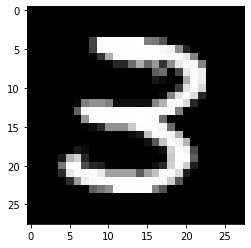

In [ ]:
pic = plt.imshow(X_sample[20].squeeze(), cmap = 'gray')

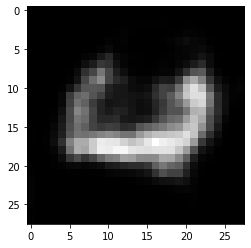

In [ ]:
plt.imshow(autoencoder.predict(np.expand_dims(3*X_sample[20], 0)).squeeze(), cmap = 'gray')

In [ ]:
Z = encoder.predict(np.expand_dims(X_sample[21], 0))
Z

array([[-0.6019935 , -0.73361975, -0.51973474, -0.7121423 ]],
      dtype=float32)

[[-1.8059804  -0.73361975 -0.51973474 -0.7121423 ]]


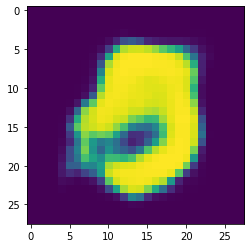

In [ ]:
# X_sample[20] (28, 28)
# np.expand_dims(X_sample[20], 0) (1, 28, 28, 1)
Z = encoder.predict(np.expand_dims(X_sample[21], 0))
i = 0
Z[0][i] = 3*Z[0][i]
print(Z)

Y_ = decoder.predict(Z)
Y_.shape
# Y (1, 28, 28, 1)
plt.imshow(Y_.squeeze())

In [ ]:
Z

array([[-4.5767366e-03,  4.8494816e+00, -1.8649137e-01, -4.3181977e-01]],
      dtype=float32)

In [ ]:
(0.5*Z)**2